<a href="https://colab.research.google.com/github/1985shree/1985shree/blob/main/app_defect_validation_with_csv_data_pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing and importing libraries

In [1]:
   ! pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
   ! python -m spacy download en_core_web_lg # download pretrained model

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-01-10 08:05:51.070243: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
# import regular modules
import pandas as pd
import numpy as np
import json
import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokenizer import Tokenizer
import re
import spacy
nlp = spacy.load('en_core_web_lg')
spacy_tokenizer = Tokenizer(nlp.vocab)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.compose import ColumnTransformer # to work in parallel on columns
from sklearn.base import BaseEstimator, TransformerMixin # to make fit_transform methods for free 
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# Importing the data in csv format and exploring the data

In [4]:
df = pd.read_csv('appdata_anon.csv')

In [5]:
df.head()

,Unnamed: 0,status,description,comments,priority,rootcause,reporter,issuekey,summary,sprint,component,application,assigne,cmt_details
0,0,0,"Build: PI7.6 FE + 8.2 BE Hotfix , App Version:...",[],P3 - Medium,NaN,John Lawrence,MSH-45790,CERT|SailorAPP| On-board | Cabin Services | I...,NaN,NaN,guy,Isabella Cruz,NaN
1,1,0,Ship parse count for housekeeping requests:\r\...,[{'author': {'accountId': '5e8b26768764110b816...,P3 - Medium,Code,Tara Hall,MSH-45793,Counts in the parse tables are not matching be...,PI8.4,NaN,left,Charles Jones,Cancelling the defect because there was slight...
2,2,0,Hi [~accountid:5ade5093027e7a2ebfcbd97e] / [~a...,[{'author': {'accountId': '5ade5093027e7a2ebfc...,P2 - High,NaN,Rebecca Barnes,MSH-45795,Magnolia | KAFKA | Ship Side Events are not co...,NaN,NaN,guy,Eric Gentry,[~accountid:5d4c220bc54e920cf3b81002] - can yo...
3,3,0,Ship side team has successfully uploaded the s...,[{'author': {'accountId': '5caee6ee6c3b6b270f4...,P2 - High,NaN,Laurie Daniel,MSH-45830,VV-Prod-Ship | VM - Bulk uploaded successfully...,NaN,"""Crew VXP""",left,Roger Oneill,FYI: [DC Support|https://virginvoyages.atlassi...
4,4,0,Hit the application url and do the booking flo...,[{'author': {'accountId': '5dcdc9960e14000dd49...,P4 - Low,NaN,Andrea Roberts,MSH-45840,DWP-QA-Spinner getting displayed in the top le...,NaN,NaN,get,Hannah Turner,[~accountid:5d9b8c9033b8de0dc69a4f9a] I don’t ...


In [6]:
df.drop(columns = ['Unnamed: 0'], inplace = True)

In [7]:
df.head()

,status,description,comments,priority,rootcause,reporter,issuekey,summary,sprint,component,application,assigne,cmt_details
0,0,"Build: PI7.6 FE + 8.2 BE Hotfix , App Version:...",[],P3 - Medium,NaN,John Lawrence,MSH-45790,CERT|SailorAPP| On-board | Cabin Services | I...,NaN,NaN,guy,Isabella Cruz,NaN
1,0,Ship parse count for housekeeping requests:\r\...,[{'author': {'accountId': '5e8b26768764110b816...,P3 - Medium,Code,Tara Hall,MSH-45793,Counts in the parse tables are not matching be...,PI8.4,NaN,left,Charles Jones,Cancelling the defect because there was slight...
2,0,Hi [~accountid:5ade5093027e7a2ebfcbd97e] / [~a...,[{'author': {'accountId': '5ade5093027e7a2ebfc...,P2 - High,NaN,Rebecca Barnes,MSH-45795,Magnolia | KAFKA | Ship Side Events are not co...,NaN,NaN,guy,Eric Gentry,[~accountid:5d4c220bc54e920cf3b81002] - can yo...
3,0,Ship side team has successfully uploaded the s...,[{'author': {'accountId': '5caee6ee6c3b6b270f4...,P2 - High,NaN,Laurie Daniel,MSH-45830,VV-Prod-Ship | VM - Bulk uploaded successfully...,NaN,"""Crew VXP""",left,Roger Oneill,FYI: [DC Support|https://virginvoyages.atlassi...
4,0,Hit the application url and do the booking flo...,[{'author': {'accountId': '5dcdc9960e14000dd49...,P4 - Low,NaN,Andrea Roberts,MSH-45840,DWP-QA-Spinner getting displayed in the top le...,NaN,NaN,get,Hannah Turner,[~accountid:5d9b8c9033b8de0dc69a4f9a] I don’t ...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5689 entries, 0 to 5688
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   status       5689 non-null   int64 
 1   description  5680 non-null   object
 2   comments     5689 non-null   object
 3   priority     5689 non-null   object
 4   rootcause    1737 non-null   object
 5   reporter     5689 non-null   object
 6   issuekey     5689 non-null   object
 7   summary      5689 non-null   object
 8   sprint       3249 non-null   object
 9   component    5229 non-null   object
 10  application  5689 non-null   object
 11  assigne      5689 non-null   object
 12  cmt_details  5280 non-null   object
dtypes: int64(1), object(12)
memory usage: 577.9+ KB


In [9]:
df.isna().sum()

status            0
description       9
comments          0
priority          0
rootcause      3952
reporter          0
issuekey          0
summary           0
sprint         2440
component       460
application       0
assigne           0
cmt_details     409
dtype: int64

In [10]:
df.drop(columns = ['rootcause', 'sprint'], inplace = True) # too many missing values for these columns

In [11]:
df.isna().sum()

status           0
description      9
comments         0
priority         0
reporter         0
issuekey         0
summary          0
component      460
application      0
assigne          0
cmt_details    409
dtype: int64

In [12]:
df.component.fillna('others', inplace = True)

In [13]:
df.cmt_details.fillna('no comment', inplace = True)

In [14]:
df.description.fillna('no description', inplace = True)

In [15]:
df.isna().sum() # all null values replaced, it looks better...

status         0
description    0
comments       0
priority       0
reporter       0
issuekey       0
summary        0
component      0
application    0
assigne        0
cmt_details    0
dtype: int64

# Visualization of data

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
df.status.value_counts()

1    3278
0    2411
Name: status, dtype: int64

In [50]:
df_application = df.groupby(['application', 'status']).agg(count_status = ('status', 'count')).reset_index()


In [51]:
df_application.head(10)

,application,status,count_status
0,ago,0,1
1,campaign,0,12
2,get,0,565
3,give,0,120
4,green,0,76
5,guy,0,874
6,guy,1,3278
7,hundred,0,20
8,if,0,10
9,its,0,14


In [60]:
df_application.application.unique()

array(['ago', 'campaign', 'get', 'give', 'green', 'guy', 'hundred', 'if',
       'its', 'left', 'part', 'quite', 'shoulder', 'take', 'thousand'],
      dtype=object)

[Text(0, 0, 'ago'),
 Text(0, 0, 'campaign'),
 Text(0, 0, 'get'),
 Text(0, 0, 'give'),
 Text(0, 0, 'green'),
 Text(0, 0, 'guy'),
 Text(0, 0, 'hundred'),
 Text(0, 0, 'if'),
 Text(0, 0, 'its'),
 Text(0, 0, 'left'),
 Text(0, 0, 'part'),
 Text(0, 0, 'quite'),
 Text(0, 0, 'shoulder'),
 Text(0, 0, 'take'),
 Text(0, 0, 'thousand')]

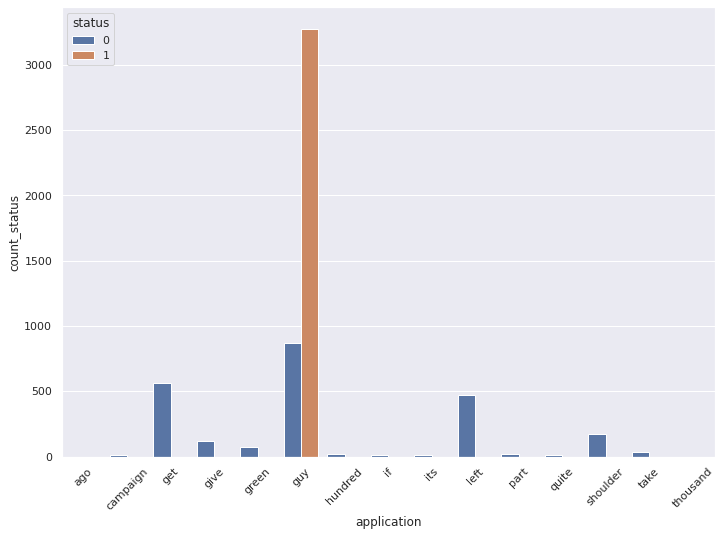

In [63]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
fig = sns.barplot(data = df_application, x = 'application', y = 'count_status', hue = 'status')
fig.set_xticklabels(labels = ['ago', 'campaign', 'get', 'give', 'green', 'guy', 'hundred', 'if',\
       'its', 'left', 'part', 'quite', 'shoulder', 'take', 'thousand'], rotation = 45)

## Only the app 'guy' got defects validated. No other app got a single one validated. We shall concentrate on the app 'guy' only, since for the other apps we may not find any rule at all. Time to slice through the data.

In [64]:
df_guy = df[df['application'] == 'guy']

In [67]:
df_guy.status.value_counts()

1    3278
0     874
Name: status, dtype: int64

In [69]:
df_guy.status.value_counts(normalize = True)

1    0.789499
0    0.210501
Name: status, dtype: float64

This is an imbalanced data. How to handle this? At first, we try without oversampline methods and try some more visualization.



In [70]:
df_guy.columns

Index(['status', 'description', 'comments', 'priority', 'reporter', 'issuekey',
       'summary', 'component', 'application', 'assigne', 'cmt_details'],
      dtype='object')

In [71]:
df_guy_priority = df.groupby(['priority', 'status']).agg(count_status = ('status', 'count')).reset_index()

In [72]:
df_guy_priority.priority.unique()

array(['P1 - Urgent', 'P2 - High', 'P3 - Medium', 'P4 - Low'],
      dtype=object)

[Text(0, 0, 'P1 - Urgent'),
 Text(0, 0, 'P2 - High'),
 Text(0, 0, 'P3 - Medium'),
 Text(0, 0, 'P4 - Low')]

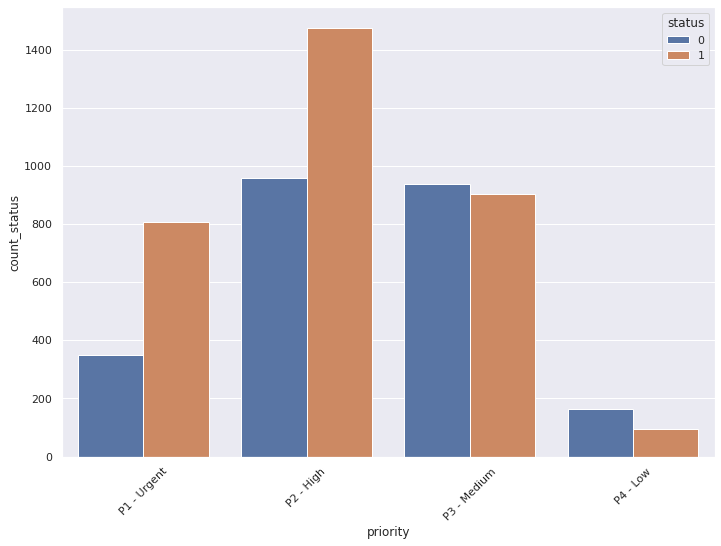

In [73]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
fig = sns.barplot(data = df_guy_priority, x = 'priority', y = 'count_status', hue = 'status')
fig.set_xticklabels(labels = ['P1 - Urgent', 'P2 - High', 'P3 - Medium', 'P4 - Low'], rotation = 45)


Visually, the priority status has an effect on the validation process. 

# Next step: classification model. We shall fit data with categorical and text data and combine them with a relevant model later on.

In [84]:
def clean_string(text,stem="None"):

    final_string = ""

    # make lower
    text = text.lower()
    
    # remove http
    text = re.sub(r"http.*\.[a-z]{2,3}","",text)

    # remove www
    text = re.sub(r"www.*\.[a-z]{2,3}","",text)
    
    # remove line breaks
    text = re.sub(r'\n','',text)

    # remove puncuation
    translator = str.maketrans('','',string.punctuation)
    text = text.translate(translator)

    # remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words.remove("don't")
    useless_words.remove('not')

    text_filtered = [word for word in text if not word in useless_words]

    # remove numbers
    text_filtered = [re.sub(r'\w*\d\w*','',w) for w in text_filtered]

    # stem or lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(text_stemmed)

    return final_string
        
def apply_clean_string(df):
   arr = df.apply(lambda x: clean_string(str(x)))
   return pd.DataFrame(arr)  

# Let's apply only categorical pipeline (skip this on 11.01.2023)

In [85]:
countvectorizer = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1), preprocessor = clean_string)
svc_classifier = LinearSVC()
vanilla_logistic = LogisticRegression()
tfidfvectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer, preprocessor = clean_string) # we will use both vectorizers
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

In [86]:
# not using text data...just categorical data
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
xgb = XGBClassifier()
log_cat_pipe = Pipeline([
                 ('one_hot_encoder', ohe),

                 ('classifier', log_reg)])
xgb_cat_pipe = Pipeline([
                 ('one_hot_encoder', ohe),

                 ('classifier', xgb)])

In [87]:
df_guy.columns 

Index(['status', 'description', 'comments', 'priority', 'reporter', 'issuekey',
       'summary', 'component', 'application', 'assigne', 'cmt_details'],
      dtype='object')

In [93]:
X_cat = df_guy[['priority', 'issuekey']]
y_cat = df_guy[['status']]

In [94]:
X_cat_train, X_cat_val, y_cat_train, y_cat_val = train_test_split(X_cat, y_cat, test_size=0.2, random_state=111)# train-val

In [95]:
params_xgb = {'classifier__max_depth' : [3, 5, 7, 10, 20]},\
              {'classifier__min_child_weight': [5, 7, 20]},\
              {'classifier__gamma': [0.0005, 0.005, 0.1]}
xgb_cat_grid = GridSearchCV(xgb_cat_pipe, param_grid = params_xgb, cv=5,
                               n_jobs=-2, verbose=1)

In [96]:
xgb_cat_grid.fit(X_cat_train, y_cat_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('one_hot_encoder',
                                        OneHotEncoder(handle_unknown='ignore',
                                                      sparse=False)),
                                       ('classifier', XGBClassifier())]),
             n_jobs=-2,
             param_grid=({'classifier__max_depth': [3, 5, 7, 10, 20]},
                         {'classifier__min_child_weight': [5, 7, 20]},
                         {'classifier__gamma': [0.0005, 0.005, 0.1]}),
             verbose=1)

In [97]:
xgb_cat_grid.best_score_

0.7883168765286712

In [100]:
xgb_cat_grid.best_params_

{'classifier__max_depth': 3}

In [98]:
pd.DataFrame(xgb_cat_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__min_child_weight,param_classifier__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,14.114413,1.165456,0.037201,0.006197,3,NaN,NaN,{'classifier__max_depth': 3},0.78797,0.789157,0.789157,0.787651,0.787651,0.788317,0.000695,1
1,15.500557,0.539619,0.041437,0.015019,5,NaN,NaN,{'classifier__max_depth': 5},0.78797,0.789157,0.789157,0.787651,0.787651,0.788317,0.000695,1
2,15.758305,1.261167,0.033181,0.001819,7,NaN,NaN,{'classifier__max_depth': 7},0.78797,0.789157,0.789157,0.787651,0.787651,0.788317,0.000695,1
3,15.304725,0.518210,0.034222,0.002039,10,NaN,NaN,{'classifier__max_depth': 10},0.78797,0.789157,0.789157,0.787651,0.787651,0.788317,0.000695,1
4,15.387083,0.566171,0.032595,0.002054,20,NaN,NaN,{'classifier__max_depth': 20},0.78797,0.789157,0.789157,0.787651,0.787651,0.788317,0.000695,1
5,13.602457,0.134529,0.033251,0.001990,NaN,5,NaN,{'classifier__min_child_weight': 5},0.78797,0.789157,0.789157,0.787651,0.787651,0.788317,0.000695,1
6,13.918154,0.799806,0.034725,0.003545,NaN,7,NaN,{'classifier__min_child_weight': 7},0.78797,0.789157,0.789157,0.787651,0.787651,0.788317,0.000695,1
7,15.081658,0.175366,0.036358,0.001026,NaN,20,NaN,{'classifier__min_child_weight': 20},0.78797,0.789157,0.789157,0.787651,0.787651,0.788317,0.000695,1
8,16.503363,1.587439,0.034794,0.002076,NaN,NaN,0.0005,{'classifier__gamma': 0.0005},0.78797,0.789157,0.789157,0.787651,0.787651,0.788317,0.000695,1
9,15.039504,0.298404,0.034639,0.003945,NaN,NaN,0.005,{'classifier__gamma': 0.005},0.78797,0.789157,0.789157,0.787651,0.787651,0.788317,0.000695,1


In [105]:
xgb_fin = XGBClassifier(max_depth = 3)
xgb_cat_pipe_fin = Pipeline([
                 ('one_hot_encoder', ohe),

                 ('classifier', xgb_fin)])

In [106]:
xgb_cat_pipe_fin.fit(X_cat_train, y_cat_train)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('one_hot_encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False)),
                ('classifier', XGBClassifier())])

In [107]:
xgb_fin_pred = xgb_cat_pipe_fin.predict(X_cat_val)
xgb_fin_score = accuracy_score(xgb_fin_pred, y_cat_val)

In [109]:
xgb_fin_score

0.7942238267148014

# Let's apply only text pipeline (continue with troubleshooting this part on 11.01.2023)

In [110]:
count_pipe = Pipeline([
                 ('vectorizer', countvectorizer),

                 ('classifier', svc_classifier)])

In [111]:
tf_pipe = Pipeline([
                 ('vectorizer', tfidfvectorizer),
                 ('classifier', svc_classifier)])

In [112]:
df_guy.columns 

Index(['status', 'description', 'comments', 'priority', 'reporter', 'issuekey',
       'summary', 'component', 'application', 'assigne', 'cmt_details'],
      dtype='object')

In [128]:
df_guy.

64

In [129]:
X_txt = df_guy[['description', 'summary', 'component', 'cmt_details']]
y_txt = df_guy['status']

In [130]:
X_txt_train, X_txt_val, y_txt_train, y_txt_val = train_test_split(X_txt, y_txt, test_size=0.2, random_state=111)# train-val

In [134]:
count_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vectorizer', 'classifier', 'vectorizer__analyzer', 'vectorizer__binary', 'vectorizer__decode_error', 'vectorizer__dtype', 'vectorizer__encoding', 'vectorizer__input', 'vectorizer__lowercase', 'vectorizer__max_df', 'vectorizer__max_features', 'vectorizer__min_df', 'vectorizer__ngram_range', 'vectorizer__preprocessor', 'vectorizer__stop_words', 'vectorizer__strip_accents', 'vectorizer__token_pattern', 'vectorizer__tokenizer', 'vectorizer__vocabulary', 'classifier__C', 'classifier__class_weight', 'classifier__dual', 'classifier__fit_intercept', 'classifier__intercept_scaling', 'classifier__loss', 'classifier__max_iter', 'classifier__multi_class', 'classifier__penalty', 'classifier__random_state', 'classifier__tol', 'classifier__verbose'])

In [143]:
svc_params = {'classifier__penalty': ['l1', 'l2'],
              'classifier__C': [0.1, 1, 10, 100, 1000], 
              'classifier__kernel': ['linear', 'rbf']} 
count_grid = GridSearchCV(count_pipe, param_grid = svc_params, cv=4,
                               n_jobs=-2, verbose=1)


In [ ]:
count_grid.fit(X_txt_train, y_txt_train)